# CS5489 - Tutorial 8
## Face Detection with MLPs

In this tutorial you will train an MLP to detect whether there is a face in a small image patch.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
import skimage.io
import skimage.color
import skimage.transform
from scipy import ndimage

import warnings
warnings.filterwarnings('ignore')

Next we will load keras and tensorflow.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import struct
K.set_image_data_format('channels_last')

In [3]:
import sys
print("Python:", sys.version, "Keras:", keras.__version__, "TF:", tf.__version__)

Python: 3.8.16 | packaged by conda-forge | (default, Feb  1 2023, 15:53:35) [MSC v.1929 64 bit (AMD64)] Keras: 2.11.0 TF: 2.11.1


##  Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and place it in the same directory as this ipynb file.  **Do not unzip it.** Then run the following cell to load the images.

In [4]:
imgdata = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# the dataset is too big, so subsample the training and test sets...
# reduce training set by a factor of 4
train_subsample = 1
train_counter = [0, 0]
# maximum number of samples in each class for test set
test_maxsample = 472
test_counter = [0, 0]

# load the zip file
filename = 'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):
        
        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        loadme = False
        if fset == 'train':
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            train_counter[myclass] += 1
        elif fset == 'test':
            if test_counter[myclass] < test_maxsample:
                loadme = True
            test_counter[myclass] += 1
            
        if (loadme):
            # open file in memory, and parse as an image
            myfile = zfile.open(name)
            #img = matplotlib.image.imread(myfile)
            img = skimage.io.imread(myfile, as_gray=True)
            myfile.close()
            
            # append data
            imgdata[fset].append(img)
            classes[fset].append(myclass)

        
zfile.close()
imgsize = img.shape

print(len(imgdata['train']))
print(len(imgdata['test']))
trainclass2start = sum(classes['train'])

6977
944


Next we will convert the list of images into a block (array) of images for easier processing.

In [5]:
# convert list to numpy array
trainY = asarray(classes['train'])
testY  = asarray(classes['test'])

# convert class labels to binary indicators
trainYb = keras.utils.to_categorical(trainY)
testYb  = keras.utils.to_categorical(testY)

# convert list of ndarray to ndarray
trainI = asarray(imgdata['train']).reshape((6977,19,19,1))
testI  = asarray(imgdata['test']).reshape((944,19,19,1))

# cleanup memory
del imgdata

# shuffle the data (since it is in order by class)
random.seed(123)
inds1 = random.permutation(len(trainI)).tolist()
inds2 = random.permutation(len(testI)).tolist()
trainYb = trainYb[inds1]
testYb  = testYb[inds2]
trainY = trainY[inds1]
testY  = testY[inds2]
trainI = trainI[inds1]
testI = testI[inds2]

print(trainI.shape)
print(testI.shape)

(6977, 19, 19, 1)
(944, 19, 19, 1)


Each image is a 19x19x1 array of pixel values.  The last dimension is the number of channels in the image - in this case the image is grayscale, so there is only 1 channel.  Run the below code to show an example:

(19, 19)


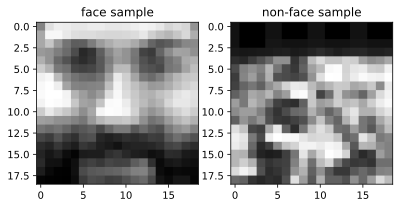

In [6]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(squeeze(trainI[1]), cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(squeeze(trainI[2]), cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

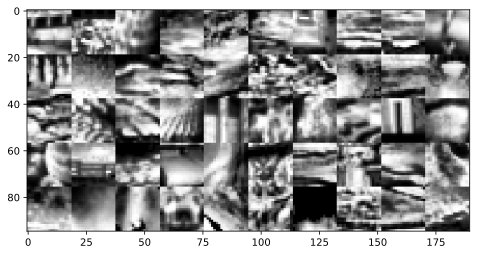

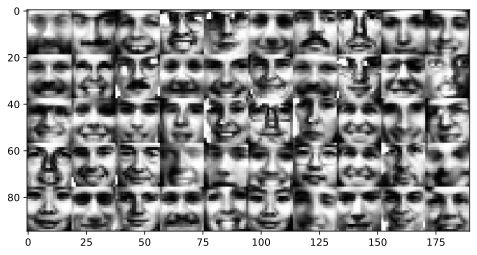

In [7]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(squeeze(X[i]))
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show images in a plot
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    # nc is the number of columns
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                if isinstance(titles, str):
                    plt.title(titles.format(idx))
                else:
                    plt.title(titles[idx])
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()

# show a few images
plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,0]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,1]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

Next we will generate the training/validation set from the training data.

In [8]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(trainI, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4488)

# make validation data
validsetI = (validI, validYb)

print(vtrainI.shape)
print(validI.shape)

(6279, 19, 19, 1)
(698, 19, 19, 1)


Here are some useful functions.

In [9]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    
    if 'accuracy' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['accuracy'], 'b', label="training acc ({:.4f})".format(history.history['accuracy'][-1]))
        ax2.plot(history.history['val_accuracy'], 'b--', label="validation acc ({:.4f})".format(history.history['val_accuracy'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')
        



Now let's try a simple logistic regression classifier, trained using Keras. Since the inputs are images, we will convert the input image into a vector using the "Flatten" layer first.

Epoch 8: early stopping
test accuracy: 0.6684322033898306


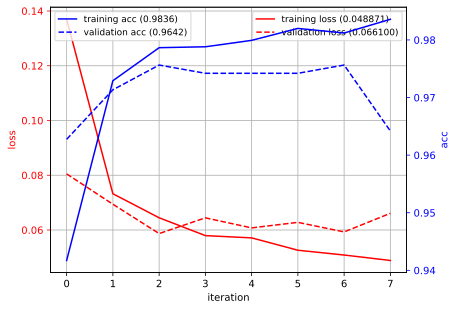

In [10]:
# initialize random seed
K.clear_session()
random.seed(4487)
tf.random.set_seed(4487)

# build the network for logistic regression
nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # vectorize the input image
nn.add(Dense(units=2, activation='softmax'))  # classification layer (2 classes)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',      # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI,  # specify the validation set
                 verbose=False)

plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

## Detection using MLP

Train an MLP to classify an image patch as face or not face.  Use  `vtrainI` and `vtrainY` as the training set and `validsetI` as the validation set.  You can try different architectures, and adjust values of the learning rates, number of iterations, early stopping to get a good result.  Use a large batch size (e.g., 50) to speed up the training time.  Remember to add the `callbacks` so that you can monitor the training process.

(6279, 19, 19, 1)
(6279, 2)
Epoch 23: early stopping
test accuracy: 0.690


0.6896186440677966

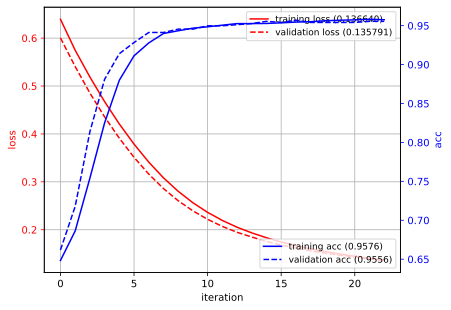

In [11]:
### INSERT YOUR CODE HERE


print(vtrainI.shape)
print(vtrainYb.shape)

def MLP():
    K.clear_session()
    random.seed(4487)
    tf.random.set_seed(4487)
    nn = Sequential()
    nn.add(Flatten(input_shape=(19,19,1)))
    nn.add(Dense(units=100, activation='relu'))
    nn.add(Dense(units=100, activation='relu'))
    # nn.add(Dense(units=100, activation='relu'))
    # nn.add(Dense(units=100, activation='relu'))
    nn.add(Dense(units=2, activation='softmax'))
    return nn

def train_MLP(lr, delta, patience=10, epochs=100, batch_size=50):
    nn = MLP()
    # early stopping criteria
    earlystop = keras.callbacks.EarlyStopping(
                monitor='val_accuracy',      # use validation accuracy for stopping
                min_delta=delta, patience=patience,
                verbose=1, mode='auto')
    callbacks_list = [earlystop]

    # compile and fit the network
    nn.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True),
            metrics=['accuracy']
            )
    history = nn.fit(vtrainI, vtrainYb, epochs=epochs, batch_size=batch_size,
                    callbacks=callbacks_list,
                    validation_data=validsetI,  # specify the validation set
                    verbose=False)
    plot_history(history)
    predY = argmax(nn.predict(testI, verbose=False), axis=-1)
    acc = metrics.accuracy_score(testY, predY)
    print( "test accuracy: {:.3f}".format(acc) )
    return acc

# for lr in [1e-4, 1e-3, 1e-2, 1e-1]:
#     print("learning rate = {:.0e}".format(lr))
#     train_MLP(lr=lr, delta=1e-4)
#
# for delta in [1e-4, 1e-3, 1e-2, 1e-1]:
#     print("delta = {:.0e}".format(delta))
#     train_MLP(lr=lr, delta=delta)

train_MLP(lr=1e-4, delta=1e-2)

_How does the MLP compare to the linear and non-linear classifiers that you tried in Tutorial 4?_
- **INSERT YOUR ANSWER HERE**
- The performance of MLP on the test set when stacked up to three layers has surpassed all previous linear and nonlinear algorithms.
- And it converges perfectly in training and validation, indicating a good expressiveness.
- The learning rate has a great impact, and in addition, the number of parameters has increased, and how to deal with getting the optimal set of parameters has become a new difficulty.
- Performance:
- Based on three layers.
- lr in [1e-4, 1e-3, 1e-2, 1e-1], Test ACC in [0.669, 0.583, 0.627,0.579]
- delta in [1e-4, 1e-3, 1e-2, 1e-1], Test ACC in [0.599, 0.611, 0.642,0.624]
- The best performance is achieved when the learning rate is 1e-4 and the delta is 1e-2.
- hidden layer in [1, 2, 3, 4], Test ACC in [0.697, 0.689, 0.636,0.6334]

## Data Augmentation

The reason why we are not getting good accuracy with MLP is because there is not a lot of data, only ~7000 training images, compared to the number of parameters in the MLP.

Augmenting the training data with permutations  (e.g., scaling, rotating, skewing, flipping) is a good way to create more "data" for training the network.
This can prevent the MLP from overfitting, and improve its generalization.  We will use the built-in `ImageDataGenerator` to apply geometric transformations.

We can also add per-pixel noise or transformations. We define a few functions for adding per-pixel noise.  The following functions will add Gaussian pixel noise, add corruption noise (setting some input pixels to 0), scale and shift pixel values (changing contrast and brightness).

In [12]:
def add_gauss_noise(X, sigma2=0.05):
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

def add_corrupt_noise(X, p=0.1):
    # apply pixel corruption (zero out value) with probability p
    return X * random.binomial(1, 1-p, X.shape)

def add_scale_shift(X, sigma2=0.1, alpha2=0.2):
    # randomly scale and shift the pixel values (same for each image)
    # Xnew = a X + b
    # a is sampled from a Gaussian with mean 1, and variance sigma2
    # b is sampled from a Gaussian with mean 0, and variance alpha2
    if X.ndim == 3:
        dshape = (X.shape[0],1,1)
    elif X.ndim == 4:
        dshape = (X.shape[0],1,1,1)
    else:
        dshape = (1,)
    a = random.normal(1,sigma2, dshape)
    b = random.normal(0,alpha2, dshape)
    return minimum(maximum( a*X + b, 0.0), 1.0)

Next, we define a function for adding per-pixel noise (in this case just Gaussian noise). The noise is included using the `preprocessing_function` input of the `ImageDataGenerator`.

In [13]:
# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

Next we can show some examples of augmented images. Run the code below to see different random augmentations.

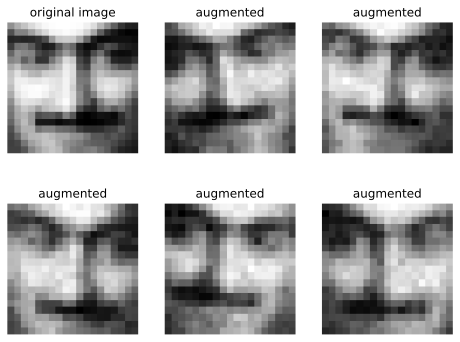

In [14]:
img = trainI[4]
imgs = [img[:,:,0]]

cnt = 0
for augimg, augy in datagen.flow(img.reshape(1,19,19,1), [1], batch_size=1):
    imgs.append(augimg[0,:,:,0])
    cnt += 1
    if cnt > 4:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

titles = ['original image', 'augmented', 'augmented', 'augmented', 'augmented', 'augmented']
plt.figure(figsize=(8,6))
show_imgs(imgs, nc=3, titles=titles)

The augmented images look similar to the original image, but contain small differences that the network can use to learn more about the class.

Now let's try training logistic regression with data augmentation. Instead sending the X,Y data to `fit`, we now  send it through the ImageDataGenerator first.  We disable early stopping so that the network sees more noisy data.

In [15]:
# initialize random seed
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

# build the network for logistic regression
nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # vectorize the input image
nn.add(Dense(units=2, activation='softmax'))  # classification layer (2 classes)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',             # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

# fit with data generator
history = nn.fit(
            datagen.flow(vtrainI, vtrainYb, batch_size=100),  # data from generator
            steps_per_epoch=len(vtrainI)/100,    # should be number of batches per epoch
            epochs=50,
            #callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)


Epoch 1/50
62/62 [==============================] - 2s 24ms/step - loss: 0.3327 - accuracy: 0.8686 - val_loss: 0.1361 - val_accuracy: 0.9441
Epoch 2/50
62/62 [==============================] - 2s 24ms/step - loss: 0.1801 - accuracy: 0.9266 - val_loss: 0.1157 - val_accuracy: 0.9570
Epoch 3/50
62/62 [==============================] - 1s 23ms/step - loss: 0.1684 - accuracy: 0.9334 - val_loss: 0.1597 - val_accuracy: 0.9327
Epoch 4/50
62/62 [==============================] - 1s 22ms/step - loss: 0.1668 - accuracy: 0.9325 - val_loss: 0.1354 - val_accuracy: 0.9456
Epoch 5/50
62/62 [==============================] - 1s 21ms/step - loss: 0.1623 - accuracy: 0.9350 - val_loss: 0.1058 - val_accuracy: 0.9556
Epoch 6/50
62/62 [==============================] - 1s 21ms/step - loss: 0.1577 - accuracy: 0.9365 - val_loss: 0.0898 - val_accuracy: 0.9685
Epoch 7/50
62/62 [==============================] - 1s 20ms/step - loss: 0.1552 - accuracy: 0.9377 - val_loss: 0.0862 - val_accuracy: 0.9642
Epoch 8/50
62

test accuracy: 0.6726694915254238


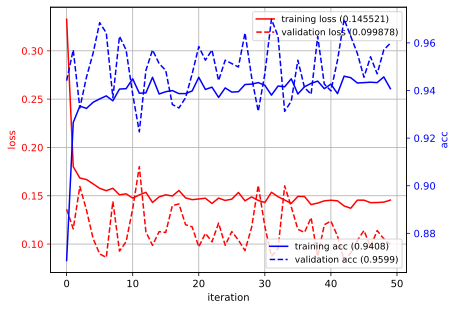

In [16]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

Using data augmentation, the test accuracy improves from 0.66 to 0.69!

Now train your best MLP from the previous section using data augmentation. 
Try different per-pixel noise levels, and different options of the ImageDataGenerator (see [here](https://keras.io/preprocessing/image/)), 
and combinations of them.  Hopefully you should be able to improve the accuracy! 

In [17]:
### INSERT YOUR CODE HERE ###

In [24]:
from tqdm import tqdm

# gauss corrupt shift
def addGuassNoise1(X):
    return add_gauss_noise(X, 0.1)
def addGuassNoise2(X):
    return add_gauss_noise(X, 0.2)
def addGuassNoise3(X):
    return add_gauss_noise(X, 0.3)

def addCorruptNoise1(X):
    return add_corrupt_noise(X, p=0.1)
def addCorruptNoise2(X):
    return add_corrupt_noise(X, p=0.2)
def addCorruptNoise3(X):
    return add_corrupt_noise(X, p=0.3)

def addScaleShift1(X):
    return add_scale_shift(X,sigma2=0.1, alpha2=0.2)
def addScaleShift2(X):
    return add_scale_shift(X,sigma2=0.2, alpha2=0.2)
def addScaleShift3(X):
    return add_scale_shift(X,sigma2=0.2, alpha2=0.3)
def addScaleShift4(X):
    return add_scale_shift(X,sigma2=0.3, alpha2=0.3)
def addScaleShift5(X):
    return add_scale_shift(X,sigma2=0.3, alpha2=0.4)
def addScaleShift6(X):
    return add_scale_shift(X,sigma2=0.4, alpha2=0.4)

comb1 = lambda x : addGuassNoise1(addCorruptNoise1(x))
comb2 = lambda x : addGuassNoise1(addScaleShift1(x))
comb3 = lambda x : addCorruptNoise1(addScaleShift1(x))
comb4 = lambda x : addGuassNoise1(addCorruptNoise1(addScaleShift1(x)))

In [26]:
addNoise_arr = [addGuassNoise1, addGuassNoise2, addGuassNoise3, addCorruptNoise1, addCorruptNoise2, addCorruptNoise3, addScaleShift1, addScaleShift2, addScaleShift3, addScaleShift4, addScaleShift5, addScaleShift6, comb1, comb2, comb3, comb4]

for addNoise in tqdm(addNoise_arr):
    # build the data augmenter
    datagen = ImageDataGenerator(
        rotation_range=10,         # image rotation
        width_shift_range=0.05,     # image shifting
        height_shift_range=0.05,    # image shifting
        shear_range=0.05,           # shear transformation
        zoom_range=0.05,            # zooming
        horizontal_flip=True,       # horizontal flipping
        preprocessing_function=addNoise,  # add per-pixel noise
        data_format='channels_last')

    K.clear_session()
    random.seed(4487)
    tf.random.set_seed(4487)
    # build the network for logistic regression
    nn = MLP()
    earlystop = keras.callbacks.EarlyStopping(
                monitor='val_accuracy',             # use validation accuracy for stopping
                min_delta=0.001, patience=10,
                verbose=1, mode='auto')
    # compile and fit the network
    nn.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True),
            metrics=['accuracy']  # also calculate accuracy during training
            )
    # fit with data generator
    history = nn.fit_generator(
                datagen.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
                steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
                epochs=50,
                validation_data=validsetI, verbose=False)

    # plot_history(history)
    predY = argmax(nn.predict(testI, verbose=False), axis=-1)
    acc = metrics.accuracy_score(testY, predY)
    print("test accuracy, NN with au: {:.3f}".format(acc) )


  6%|▋         | 1/16 [01:13<18:15, 73.01s/it]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


test accuracy, NN with au: 0.794


 12%|█▎        | 2/16 [02:18<15:57, 68.36s/it]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


test accuracy, NN with au: 0.836


 19%|█▉        | 3/16 [03:24<14:37, 67.49s/it]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


test accuracy, NN with au: 0.814


 25%|██▌       | 4/16 [04:29<13:15, 66.30s/it]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


test accuracy, NN with au: 0.803


 31%|███▏      | 5/16 [05:32<11:56, 65.16s/it]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


test accuracy, NN with au: 0.836


 38%|███▊      | 6/16 [06:35<10:45, 64.54s/it]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


test accuracy, NN with au: 0.865


 44%|████▍     | 7/16 [07:41<09:44, 64.95s/it]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


test accuracy, NN with au: 0.810


 50%|█████     | 8/16 [08:46<08:40, 65.02s/it]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


test accuracy, NN with au: 0.783


 56%|█████▋    | 9/16 [09:52<07:36, 65.20s/it]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


test accuracy, NN with au: 0.752


 62%|██████▎   | 10/16 [10:57<06:31, 65.27s/it]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


test accuracy, NN with au: 0.815


 69%|██████▉   | 11/16 [12:02<05:25, 65.10s/it]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


test accuracy, NN with au: 0.808


 75%|███████▌  | 12/16 [13:07<04:20, 65.19s/it]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


test accuracy, NN with au: 0.812


 81%|████████▏ | 13/16 [14:13<03:16, 65.53s/it]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


test accuracy, NN with au: 0.855


 88%|████████▊ | 14/16 [15:21<02:12, 66.20s/it]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


test accuracy, NN with au: 0.837


 94%|█████████▍| 15/16 [16:28<01:06, 66.54s/it]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


test accuracy, NN with au: 0.827


100%|██████████| 16/16 [17:40<00:00, 66.27s/it]

test accuracy, NN with au: 0.832


_Which type of augmentation improves the accuracy the most?  Why?  How does NN with data augmentation compare with your work in Tutorial 4?_ 
- **INSERT YOUR ANSWER HERE**
- Corrupt noise has the biggest boost to the model, and the features are very well discriminated when the probability is boosted to 0.4. This is because such features that are suddenly set to 0 are well identified, so the enhanced images are easily discriminated and make the model metrics look much better.
- Because of the improvement of the model learning ability, the performance is improved a lot compared to T4 image enhancement, and the features can be seen to be learned by the model in recognizing the noise sensitivity.

- Performance
- Gaussian noise: [0.1, 0.2, 0.3] = [0.794, 0.836, 0.814]
- Corrupt noise: [0.1, 0.2, 0.3] = [0.803, 0.836, 0.865]
- Scale shift: [0.1,0.2; 0.2,0.2; 0.2,0.3;0.3,0.3;0.3,0.4;0.4,0.4] = [0.810, 0.783, 0.752, 0.815, 0.808, 0.812]
- Combination: [1, 2, 3] = [0.855, 0.837, 0.827, 0.832]

# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [27]:
fname = "nasa-small.png"

(210, 480)


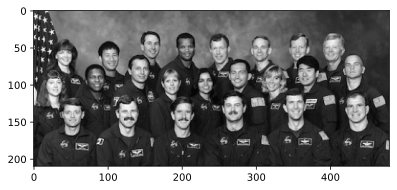

In [28]:
# load image
testimg = skimage.io.imread(fname, as_gray=True)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [29]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3], 1))
print(patches2.shape)

# histogram equalize patches (improves contrast)
#newI = empty(patches2.shape)
#for i in range(patches2.shape[0]):
#    newI[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])
newI = patches2

(5568, 19, 19, 1)


Now predict using your classifier.  The extracted images are in `newI`.

In [30]:
### YOUR CODE HERE
prednewY = argmax(nn.predict(newI, verbose=False), axis=-1)

Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

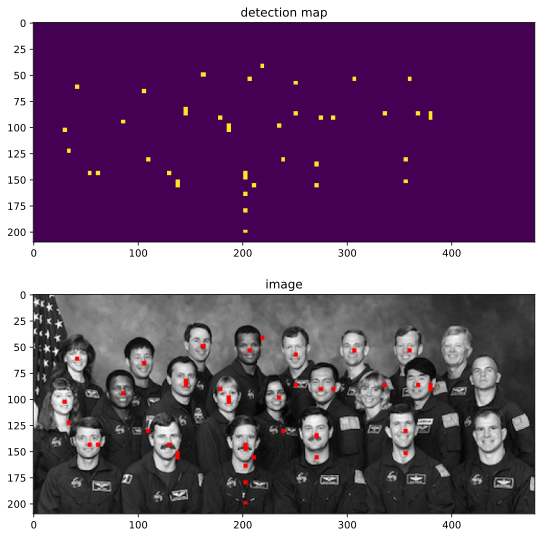

In [31]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector do compared to the last version?_
- **INSERT YOUR ANSWER HERE**
- Learned a lot of more abstract features, resulting will will let the point focus on a person, or a piece of the face are missed.

You can try it on your own images.  The faces should all be around 19x19 pixels though.
We only used 1/8 of the training data. Try using more data to train it!

(792, 1000)


(-0.5, 999.5, 791.5, -0.5)

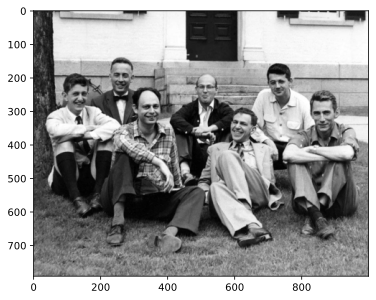

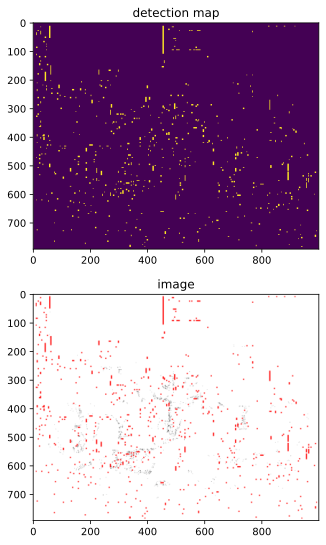

In [42]:
fname = "ai.jpeg"
testimg2 = skimage.io.imread(fname, as_gray=True)

# convert to grayscale
print(testimg2.shape)
plt.imshow(testimg2, cmap='gray')

step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg2, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3], 1))

newI = patches2
prednewY = argmax(nn.predict(newI, verbose=False), axis=-1)

imgY = prednewY.reshape(psize[0], psize[1])
# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg2.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg2.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg2.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg2.shape[1]-imgY2.shape[1]))))

# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg2
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')
